# Gaussian Mixture Model

In [3]:
from __future__ import print_function
import torch
import torch.utils.data
import numpy as np

!pip install matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

seed = 0
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

### toy dataset

In [2]:
# https://angusturner.github.io/generative_models/2017/11/03/pytorch-gaussian-mixture-model.html
def sample(mu, var, nb_samples=500):
    """
    Return a tensor of (nb_samples, features), sampled
    from the parameterized gaussian.
    :param mu: torch.Tensor of the means
    :param var: torch.Tensor of variances (NOTE: zero covars.)
    """
    out = []
    for i in range(nb_samples):
        out += [
            torch.normal(mu, var.sqrt())
        ]
    return torch.stack(out, dim=0)


# generate some clusters
cluster1 = sample(
    torch.Tensor([1.5, 2.5]),
    torch.Tensor([1.2, .8]),
    nb_samples=150
)

cluster2 = sample(
    torch.Tensor([7.5, 7.5]),
    torch.Tensor([.75, .5]),
    nb_samples=50
)

cluster3 = sample(
    torch.Tensor([8, 1.5]),
    torch.Tensor([.6, .8]),
    nb_samples=100
)


def plot_2d_sample(sample_dict):
    x = sample_dict["x"][:,0].data.numpy()
    y = sample_dict["x"][:,1].data.numpy()
    plt.plot(x, y, 'gx')

    plt.show()

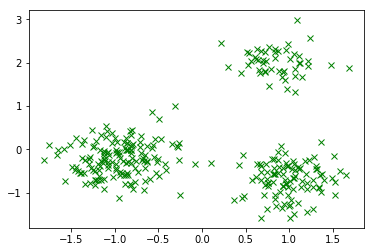

In [3]:
# create the dummy dataset, by combining the clusters.
samples = torch.cat([cluster1, cluster2, cluster3])
samples = (samples-samples.mean(dim=0)) / samples.std(dim=0)
samples_dict = {"x": samples}

plot_2d_sample(samples_dict)

## GMM

In [4]:
from pixyz.distributions import Normal, Categorical
from pixyz.distributions.mixture_distributions import MixtureModel
from pixyz.utils import print_latex

z_dim = 3  # the number of mixture
x_dim = 2

distributions = []
for i in range(z_dim):
    loc = torch.randn(x_dim)
    scale = torch.empty(x_dim).fill_(0.6)
    distributions.append(Normal(loc=loc, scale=scale, var=["x"], name="p_%d" %i))

probs = torch.empty(z_dim).fill_(1. / z_dim)
prior = Categorical(probs=probs, var=["z"], name="p_{prior}")

In [5]:
p = MixtureModel(distributions=distributions, prior=prior)
print(p)
print_latex(p)

Distribution:
  p(x) = p_{0}(x|z=0)p_{prior}(z=0) + p_{1}(x|z=1)p_{prior}(z=1) + p_{2}(x|z=2)p_{prior}(z=2)
Network architecture:
  MixtureModel(
    name=p, distribution_name=Mixture Model,
    var=['x'], cond_var=[], input_var=[], features_shape=torch.Size([])
    (distributions): ModuleList(
      (0): Normal(
        name=p_{0}, distribution_name=Normal,
        var=['x'], cond_var=[], input_var=[], features_shape=torch.Size([2])
        (loc): torch.Size([1, 2])
        (scale): torch.Size([1, 2])
      )
      (1): Normal(
        name=p_{1}, distribution_name=Normal,
        var=['x'], cond_var=[], input_var=[], features_shape=torch.Size([2])
        (loc): torch.Size([1, 2])
        (scale): torch.Size([1, 2])
      )
      (2): Normal(
        name=p_{2}, distribution_name=Normal,
        var=['x'], cond_var=[], input_var=[], features_shape=torch.Size([2])
        (loc): torch.Size([1, 2])
        (scale): torch.Size([1, 2])
      )
    )
    (prior): Categorical(
      name=p

<IPython.core.display.Math object>

In [6]:
post = p.posterior()
print(post)
print_latex(post)

Distribution:
  p(z|x) = \frac{p(z,x)}{p(x)}
Network architecture:
  PosteriorMixtureModel(
    name=p, distribution_name=Mixture Model (Posterior),
    var=['x'], cond_var=[], input_var=[], features_shape=torch.Size([])
    (p): MixtureModel(
      name=p, distribution_name=Mixture Model,
      var=['x'], cond_var=[], input_var=[], features_shape=torch.Size([])
      (distributions): ModuleList(
        (0): Normal(
          name=p_{0}, distribution_name=Normal,
          var=['x'], cond_var=[], input_var=[], features_shape=torch.Size([2])
          (loc): torch.Size([1, 2])
          (scale): torch.Size([1, 2])
        )
        (1): Normal(
          name=p_{1}, distribution_name=Normal,
          var=['x'], cond_var=[], input_var=[], features_shape=torch.Size([2])
          (loc): torch.Size([1, 2])
          (scale): torch.Size([1, 2])
        )
        (2): Normal(
          name=p_{2}, distribution_name=Normal,
          var=['x'], cond_var=[], input_var=[], features_shape=torc

<IPython.core.display.Math object>

In [7]:
def get_density(N=200, x_range=(-5, 5), y_range=(-5, 5)):
    x = np.linspace(*x_range, N)
    y = np.linspace(*y_range, N)
    x, y = np.meshgrid(x, y)
    
    # get the design matrix
    points = np.concatenate([x.reshape(-1, 1), y.reshape(-1, 1)], axis=1)
    points = torch.from_numpy(points).float()
    
    pdf = p.prob().eval({"x": points}).data.numpy().reshape([N, N])
    
    return x, y, pdf

In [8]:
def plot_density_3d(x, y, loglike):
    fig = plt.figure(figsize=(10, 10))    
    ax = fig.gca(projection='3d')
    ax.plot_surface(x, y, loglike, rstride=3, cstride=3, linewidth=1, antialiased=True,
                    cmap=cm.inferno)
    cset = ax.contourf(x, y, loglike, zdir='z', offset=-0.15, cmap=cm.inferno)

    # adjust the limits, ticks and view angle
    ax.set_zlim(-0.15,0.2)
    ax.set_zticks(np.linspace(0,0.2,5))
    ax.view_init(27, -21)
    plt.show()

In [9]:
def plot_density_2d(x, y, pdf):
    fig = plt.figure(figsize=(5, 5))
    
    plt.plot(samples_dict["x"][:,0].data.numpy(), samples_dict["x"][:,1].data.numpy(), 'gx')
    
    for d in distributions:
        plt.scatter(d.loc[0,0], d.loc[0,1], c='r', marker='o')
    
    cs = plt.contour(x, y, pdf, 10, colors='k', linewidths=2)
    plt.show()

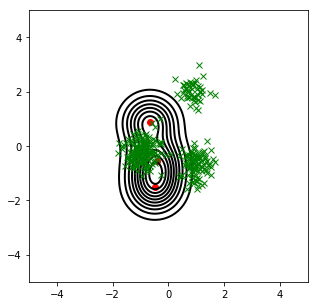

Epoch: 0, log-likelihood: -3.8614675998687744


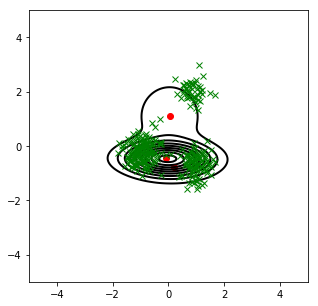

Epoch: 1, log-likelihood: -2.523808002471924


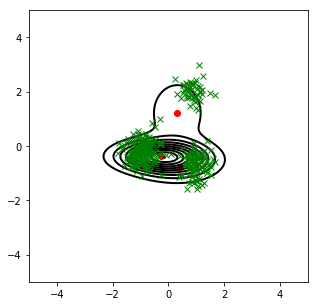

Epoch: 2, log-likelihood: -2.4456396102905273


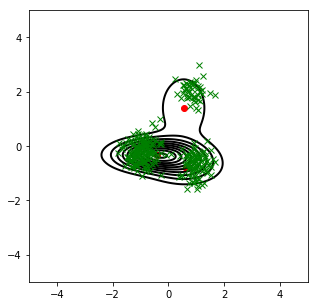

Epoch: 3, log-likelihood: -2.350588083267212


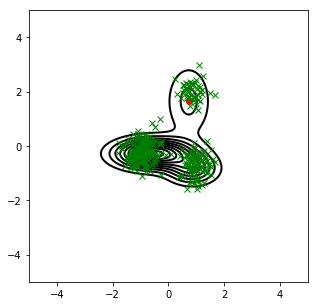

Epoch: 4, log-likelihood: -2.1976349353790283


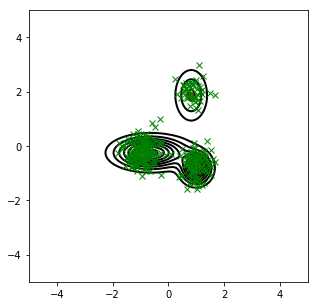

Epoch: 5, log-likelihood: -1.9780137538909912


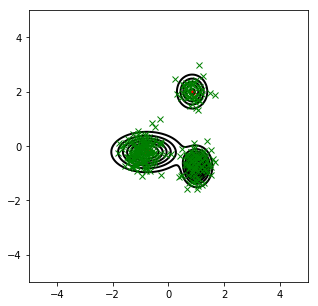

Epoch: 6, log-likelihood: -1.8074418306350708


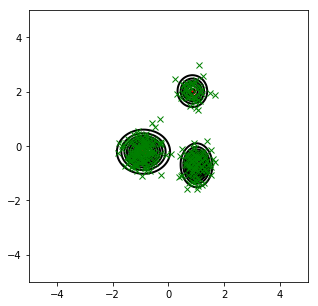

Epoch: 7, log-likelihood: -1.6936622858047485


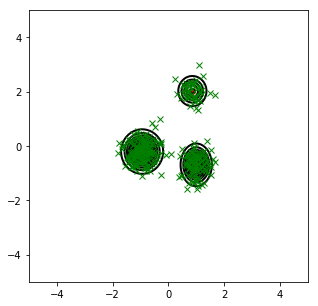

Epoch: 8, log-likelihood: -1.6597323417663574


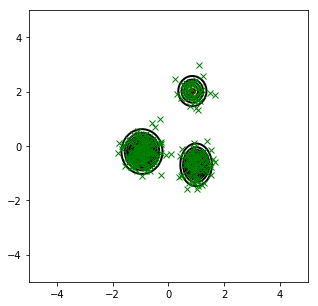

Epoch: 9, log-likelihood: -1.6591272354125977


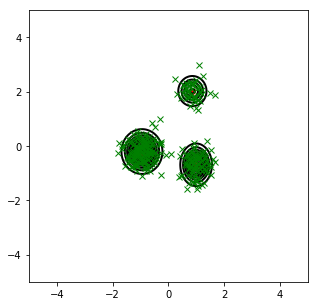

Epoch: 10, log-likelihood: -1.6591163873672485


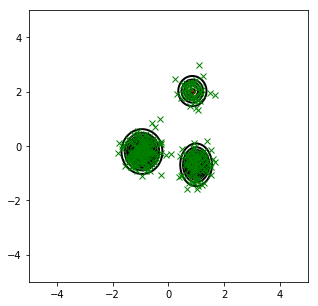

Epoch: 11, log-likelihood: -1.6591161489486694


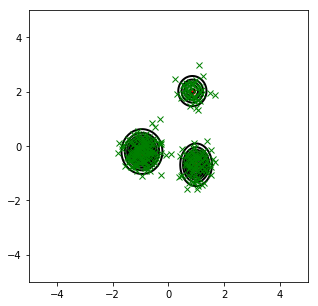

Epoch: 12, log-likelihood: -1.6591160297393799


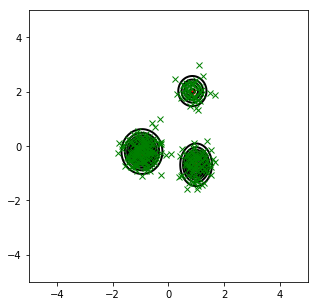

Epoch: 13, log-likelihood: -1.6591160297393799


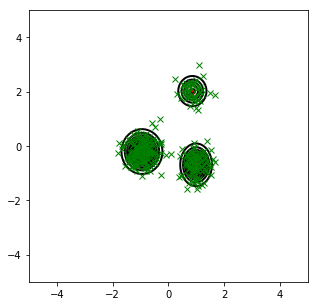

Epoch: 14, log-likelihood: -1.6591159105300903


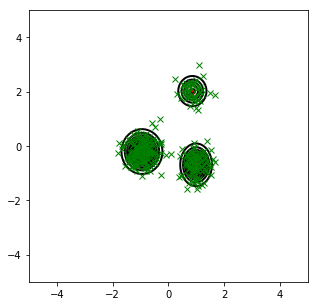

Epoch: 15, log-likelihood: -1.6591160297393799


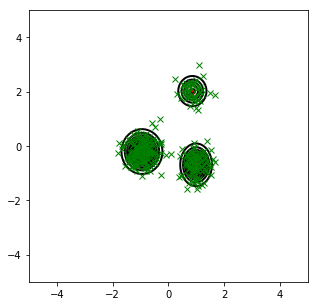

Epoch: 16, log-likelihood: -1.6591160297393799


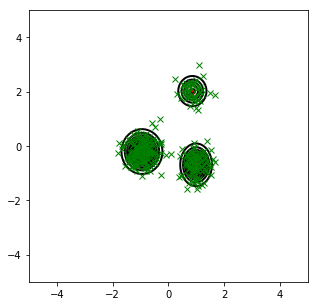

Epoch: 17, log-likelihood: -1.6591160297393799


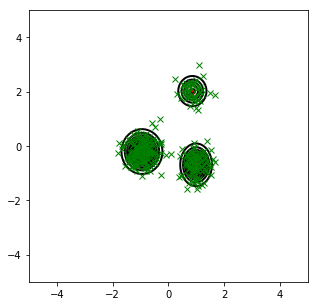

Epoch: 18, log-likelihood: -1.6591160297393799


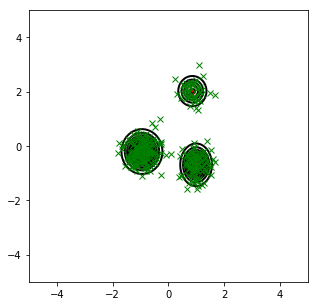

Epoch: 19, log-likelihood: -1.6591160297393799


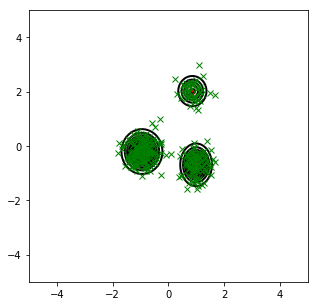

Epoch: 20, log-likelihood: -1.6591160297393799


In [10]:
eps = 1e-6
min_scale = 1e-6

# plot_density_3d(*get_density())
plot_density_2d(*get_density())
print("Epoch: {}, log-likelihood: {}".format(0, p.log_prob().mean().eval(samples_dict)))
import time
start = time.time()
for epoch in range(20):
    # E-step
    posterior = post.prob().eval(samples_dict)

    # M-step
    N_k = posterior.sum(dim=1)  # (n_mix,)
    
    # update probs
    probs = N_k / N_k.sum()  # (n_mix,)
    prior.probs[0] = probs
    
    # update loc & scale
    loc = (posterior[:, None] @ samples[None]).squeeze(1)  # (n_mix, n_dim)
    loc /= (N_k[:, None] + eps)

    cov = (samples[None, :, :] - loc[:, None, :]) ** 2  # Covariances are set to 0.
    var = (posterior[:, None, :] @ cov).squeeze(1)  # (n_mix, n_dim)
    var /= (N_k[:, None] + eps)
    scale = var.sqrt()

    for i, d in enumerate(distributions):
        d.loc[0] = loc[i]
        d.scale[0] = scale[i]

#    plot_density_3d(*get_density())
    plot_density_2d(*get_density())        
    print("Epoch: {}, log-likelihood: {}".format(epoch+1, p.log_prob().mean().eval({"x": samples}).mean()))

In [ ]:
elapsed_time = time.time() - start
print(elapsed_time)

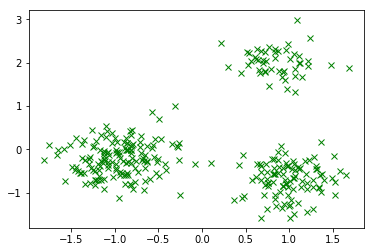

In [11]:
psudo_sample_dict = p.sample(batch_n=200)
plot_2d_sample(samples_dict)